# Кластеризация изображений транспортных средств

Даны изображения транспортных средств различных типов и с разных ракурсов. Для каждого изображения есть вектора признаков (дескрипторы), полученные с помощью разных глубоких моделей.

Задача состоит в том, чтобы, используя дескрипторы, разбить изображения на кластеры и проинтерпретировать каждый из них. Для всех вариантов дескрипторов нужно применить несколько алгоритмов кластеризации и сравнить полученные результаты. Сравнивать можно по метрикам и по тому, насколько кластера хорошо интерпретируются.

In [266]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from random import randint
from tqdm import tqdm
import pickle

# for clustering
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN

# for dimension reduction
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

In [38]:
from utils import *

## Подготовка данных

In [12]:
df_transport = pd.read_csv('transport_dataset.csv')
df_transport.shape

(416314, 2)

In [267]:
group_cars = df_transport.groupby(['car_id'])

ids = []
for k in tqdm(group_cars.groups.keys()):
    g = group_cars.get_group(k)
    n = g.iloc[0].name
    ids.append(n)

100%|██████████| 40671/40671 [00:28<00:00, 1440.01it/s]


In [325]:
# with open('descriptors/efficientnet-b7.pickle', 'rb') as f:
    # enb7 = pickle.load(f)
with open('descriptors/vdc_color.pickle', 'rb') as f:
    vdcc = pickle.load(f)
# with open('descriptors/vdc_type.pickle', 'rb') as f:
#     vdct = pickle.load(f)

In [326]:
# data = np.hstack([enb7, vdcc, vdct])
data = vdcc.copy()
# data = vdct.copy()

In [327]:
pca = PCA(0.95, random_state=42) # n_components=XXX
pca.fit(data)
pca.n_components_

92

In [328]:
n_samples = 4000
# idx = np.random.choice(data.shape[0], n_samples, replace=False)

idx = np.array(ids)
idx = np.random.choice(idx, n_samples, replace=False)

data = data[idx, :]

df = df_transport.iloc[idx, :]

data.shape, df.shape


((4000, 128), (4000, 2))

In [329]:
data = pca.transform(data)

In [333]:
tsne = TSNE(n_components=2, random_state=42, n_jobs=8)
projection = tsne.fit_transform(data)

## DBSCAN

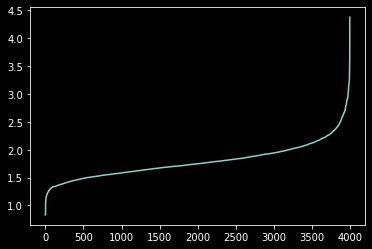

In [59]:
from sklearn.neighbors import NearestNeighbors

neigh = NearestNeighbors(n_neighbors=2)
nbrs = neigh.fit(data)
distances, indices = nbrs.kneighbors(data)

distances = np.sort(distances, axis=0)
distances = distances[:,1]

plt.plot(distances)

In [104]:
from sklearn.metrics import calinski_harabasz_score

for eps in np.arange(0.01, 2.5, step=0.15):
    for min_samples in np.arange(2, 5, step=1):
        # eps = 1.5
        dbscan = DBSCAN(
            eps=eps,
            min_samples=min_samples,
            metric='euclidean',
            #  algorithm ='auto'
        )
        dbscan.fit(data)
        c = np.unique(dbscan.labels_).shape[0]
        score = 0
        if c == 1:
            continue
        
        score = calinski_harabasz_score(data, dbscan.labels_)
        std = calc_clusters_size_std(dbscan.labels_)
        print(f'eps={eps} min_samples={min_samples} clusters={c} calinski_harabasz={score} std={std}')

eps=0.9099999999999999 min_samples=2 clusters=2 calinski_harabasz=1.9967766314919706 std=1998.0
eps=1.06 min_samples=2 clusters=2 calinski_harabasz=3.0189733318594483 std=1997.0
eps=1.06 min_samples=3 clusters=2 calinski_harabasz=3.0189733318594483 std=1997.0
eps=1.21 min_samples=2 clusters=13 calinski_harabasz=1.6239187800711292 std=1058.3719271100656
eps=1.21 min_samples=3 clusters=3 calinski_harabasz=2.767498122178393 std=1881.3754424770075
eps=1.3599999999999999 min_samples=2 clusters=51 calinski_harabasz=2.394345398304251 std=531.8318418780234
eps=1.3599999999999999 min_samples=3 clusters=20 calinski_harabasz=3.8401967050146624 std=849.075438344556
eps=1.3599999999999999 min_samples=4 clusters=10 calinski_harabasz=4.227544841549134 std=1182.6688462963757
eps=1.51 min_samples=2 clusters=95 calinski_harabasz=4.19476556593122 std=346.26516987279547
eps=1.51 min_samples=3 clusters=36 calinski_harabasz=8.628634349874293 std=575.6195588608937
eps=1.51 min_samples=4 clusters=21 calinski_

In [105]:
dbscan = DBSCAN(
    min_samples=3,
    eps=2,
)
dbscan.fit(data)
np.unique(dbscan.labels_)

array([-1,  0,  1,  2,  3,  4])

In [106]:
df.loc[:, 'label'] = dbscan.labels_

/usr/local/lib/python3.9/site-packages/pandas/core/indexing.py:1743: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)


## KMeans

In [120]:
for n_clusters in np.arange(2,  25, step=1):
    model = KMeans(n_clusters=n_clusters, random_state=42)
    model.fit(data)
    score = calinski_harabasz_score(data, model.labels_)
    std = calc_clusters_size_std(model.labels_)
    print(f'n={n_clusters} calinski_harabasz={score} std={std} i={model.inertia_}')

n=2 calinski_harabasz=1961.3761097156073 std=47.0 i=22683.9921875
n=3 calinski_harabasz=1353.8511838327252 std=808.0661414073039 i=20157.283203125
n=4 calinski_harabasz=1113.65223899999 std=515.8289445155244 i=18415.65234375
n=5 calinski_harabasz=926.7119986731042 std=331.05347000144855 i=17538.77734375
n=6 calinski_harabasz=799.5302340904573 std=238.9181635809402 i=16898.486328125
n=7 calinski_harabasz=705.0899522198517 std=240.39423403048178 i=16417.931640625
n=8 calinski_harabasz=633.6895617778245 std=182.16544677847114 i=16015.9521484375
n=9 calinski_harabasz=578.6594475286366 std=162.9758749093532 i=15654.48828125
n=10 calinski_harabasz=534.9689820634298 std=194.6160322275634 i=15322.673828125
n=11 calinski_harabasz=498.4625046334863 std=157.88561609150798 i=15030.5244140625
n=12 calinski_harabasz=464.8912437179107 std=140.88549329942464 i=14815.12109375
n=13 calinski_harabasz=438.53023565662767 std=127.4177771773955 i=14575.12109375
n=14 calinski_harabasz=414.0200126287344 std=14

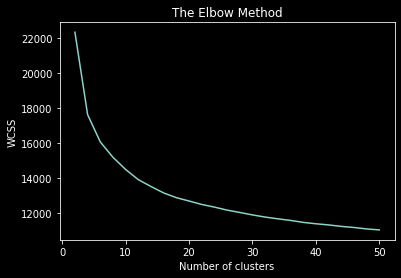

In [336]:
# Using the elbow method to find  the optimal number of clusters
# from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist

wcss = []
for i in range(2, 52, 2):
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=42)
    kmeans.fit(data)
    wcss.append(kmeans.inertia_)
    # wcss.append(sum(np.min(cdist(data, kmeans.cluster_centers_, 'euclidean'), axis=1)) / data.shape[0])
plt.plot(range(2, 52, 2), wcss)
# plt.plot(K, inertias, 'bx-')
plt.title('The Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

In [330]:
KNN_N = 12
kmeans = KMeans(n_clusters=KNN_N, init='k-means++', max_iter=300, n_init=10, random_state=42)
kmeans.fit(data)

KMeans(n_clusters=12, random_state=42)

In [331]:
df.loc[:, 'label'] = kmeans.labels_

/usr/local/lib/python3.9/site-packages/pandas/core/indexing.py:1596: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/usr/local/lib/python3.9/site-packages/pandas/core/indexing.py:1743: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)


## Визуализация

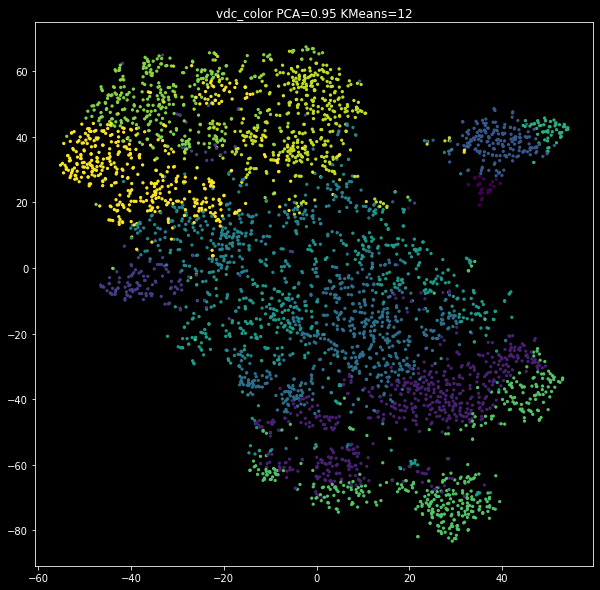

In [334]:
plt.figure(figsize=(10,10))
plt.title(f'vdc_color PCA={0.95} KMeans={KNN_N}')
plt.scatter(x=projection[:,0], y=projection[:,1], c=kmeans.labels_, s=5)

In [321]:
clusters = df.groupby(['label']).size().to_frame(name='count').reset_index()
clusters.sort_values('count', ascending=False)

label  count
0       0    631
5       5    507
10     10    427
2       2    421
3       3    403
6       6    340
1       1    308
4       4    263
8       8    263
7       7    233
9       9    168
11     11     36

<AxesSubplot:xlabel='label'>

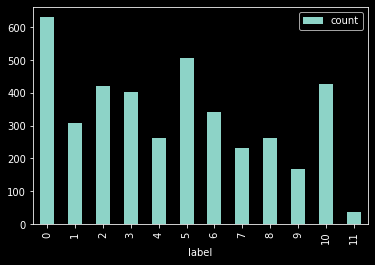

In [322]:
clusters.plot.bar(x='label', y='count')

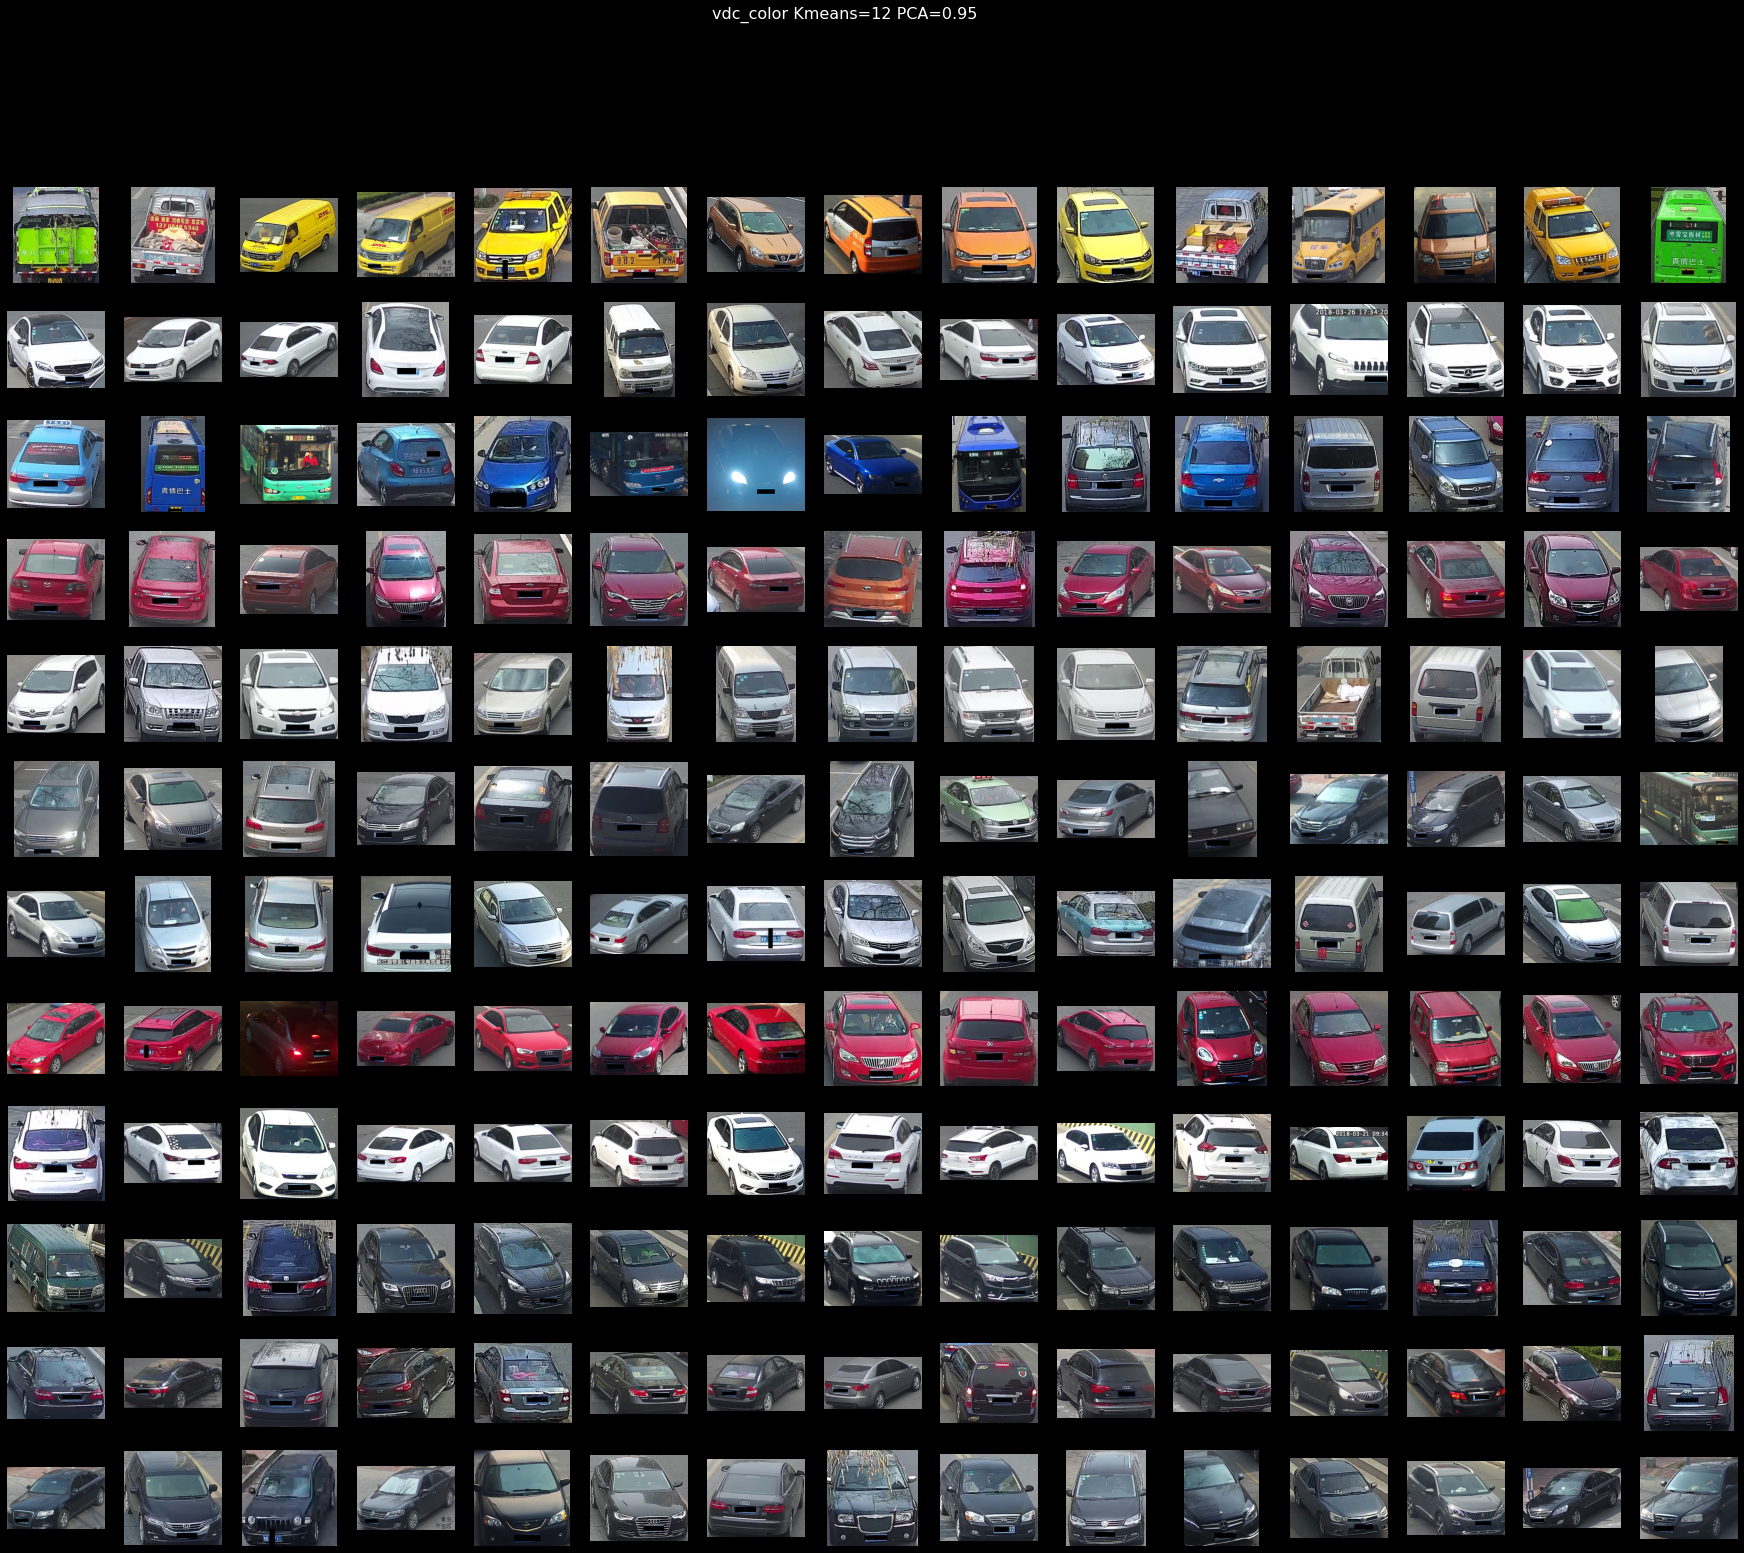

In [332]:
show_clusters(df, max_images=15, size=25, title=f'vdc_color Kmeans={KNN_N} PCA=0.95')